In [1]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import scipy as sp
import random as rn
from heapq import nlargest

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
import community as community_louvain

In [103]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [104]:
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [105]:
# remove the essential nodes from G0
ess=pd.read_csv("essential_pro.csv",header=None)
ess_pro=pd.Series.to_list(ess[1])
for i in range(len(ess_pro)):
    ess_pro[i]='4932.'+ess_pro[i]
G0.remove_nodes_from(ess_pro)

In [106]:
# narrow our selection to the proteins connected to ours
nodes = nx.shortest_path(G0,'4932.YKL126W').keys()
G=G0.subgraph(nodes)

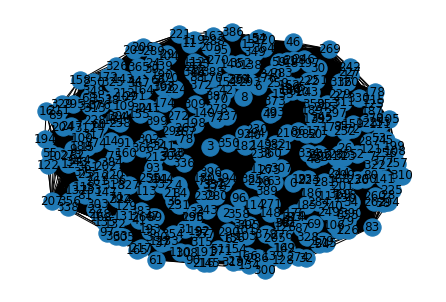

In [11]:
## Test Graph

G1 = nx.fast_gnp_random_graph(400, p= 0.5,seed=5)
nx.draw(G1, with_labels = True)

l_part = nx_comm.louvain_communities(G1, resolution = 1, seed = 1)


In [108]:
l_part

len(G1.edges())

88

In [109]:
#labelled_partition={i:part for i,part in enumerate(partition)}

In [12]:
from itertools import combinations
from collections import Counter

In [13]:
def part_graph(G_1, partition):
    N = len(partition) # Number of communities 
    labelled_partition={i:part for i,part in enumerate(partition)}
    node_dict={node:i  for i in labelled_partition for node in labelled_partition[i]}
    G = nx.Graph()
    for i in range (N): 
        G.add_node(i)

    nodes=[*G_1.nodes]


    intra_comm_combs=map(lambda x: combinations(x,2),partition)
    intra_comm_2=[*map(list,intra_comm_combs)]
    intra_comm_3=sum(intra_comm_2,[])
    
    intra_comm_edges={*map(frozenset,intra_comm_3)}
    all_edges={*map(frozenset,G1.edges)}

    inter_comm_edges=all_edges-intra_comm_edges
    
    for ed in inter_comm_edges:
        n1,n2=ed
        p1=node_dict[n1]
        p2=node_dict[n2]
        if G.has_edge(p1, p2): 
            G[p1][p2]["weight"] +=1
        else:
            G.add_edge(p1, p2, weight = 1)

    return G



In [15]:
%timeit part_graph(G1, l_part)

62.7 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def part_graph_2(G_1, partition):
    N = len(partition) # Number of communities 
    labelled_partition={i:part for i,part in enumerate(partition)}
    node_dict={node:i  for i in labelled_partition for node in labelled_partition[i]}
    G = nx.Graph()
    for i in range (N): 
        G.add_node(i)

    nodes=[*G_1.nodes]


    intra_comm_combs=map(lambda x: combinations(x,2),partition)
    intra_comm_2=[*map(list,intra_comm_combs)]
    intra_comm_3=sum(intra_comm_2,[])
    
    intra_comm_edges={*map(frozenset,intra_comm_3)}
    all_edges={*map(frozenset,G1.edges)}

    inter_comm_edges=all_edges-intra_comm_edges
    
    inter_comm_tuple=map(tuple,inter_comm_edges)

    inter_edges=map(lambda x:frozenset((node_dict[x[0]],node_dict[x[1]])),inter_comm_tuple)

    edge_weights=Counter(inter_edges)

    for t in edge_weights:
        a,b=t
        G.add_edge(a, b, weight = edge_weights[t])

    return G

In [18]:
%timeit part_graph_2(G1, l_part)

47 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
def part_graph_1(G_1, partition):
    N = len(partition) # Number of communities 
    G = nx.Graph()
    for i in range (1, N+1): 
        G.add_node(i)
    for edge in G_1.edges():
        n1 = edge[0]
        n2 = edge[1]

        for p1 in range(0,N):
            comm1 = partition[p1]
            for p2 in range(0, N):
                comm2 = partition[p2]
                if n1 in comm1 and n2 in comm2:
                    if comm1 == comm2: 
                        continue
                    if G.has_edge(p1+1, p2+1): 
                        G[p1+1][p2+1]["weight"] +=1
                    else:
                        G.add_edge(p1+1, p2+1, weight = 1)
    return G

In [20]:
%timeit part_graph_1(G1, l_part)

251 ms ± 6.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
len(G1.edges)

88

{(0, 2): Text(-0.25564640359082125, -0.496890169422619, '18'),
 (0, 1): Text(-0.24435359640917892, 0.3897087176506313, '10'),
 (1, 2): Text(0.4999999999999998, 0.10718145177198612, '13')}

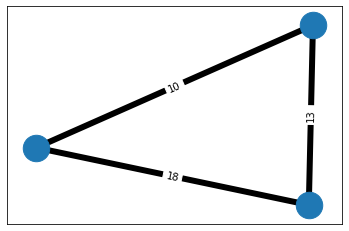

In [115]:
G2 = part_graph(G1, l_part)
edge_labels = nx.get_edge_attributes(G2, "weight")
pos = nx.spring_layout(G2, seed=7)

nx.draw_networkx_nodes(G2, pos, node_size=700)
nx.draw_networkx_edges(G2, pos, width=6)
nx.draw_networkx_edge_labels(G2, pos, edge_labels)